# 3章　word2vec

In [2]:
#必要なライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## カウントベースの問題点

前章で扱ったコーパスは語彙数が6と少なかったのに対し、実際扱うコーパスの語彙数は非常に大きな値になります。  
  
語彙数が増えると行列も巨大になり、そのような行列に対してSVDを行うのはとても現実的とは言えません。  
  
また、カウントベースの手法は**コーパス全体の統計データ**を利用して**一回の処理**で分散表現を得ていました。  
  
しかし、ニューラルネットワークを用いた推論ベースの手法では**コーパスの一部**を使い、**少しづつ重みを更新**していくミニバッチ学習を採用するので語彙数が大きくなっても対応できるという利点があります。

![alt text](../pictures/pict4.png)

それでは推論ベースの手法で行うことを詳しく見ていきましょう。  
  
推論ベースの手法は名前の通り「推論」することが主な作業になります。
  
以下のようなコンテキストが与えられたとき、"？"に何が入るのか推測をします。

![alt text](../pictures/pict5.png)

このような推論問題を何度も解くことでモデルに学習させ、その結果として単語の分散表現を得ます。  
  
これが推論ベースの手法の全体像になります。
  
今回はこの学習するモデルとしてニューラルネットワークを用います。

![alt text](../pictures/pict6.png)

## ニューラルネットワークによる単語の処理
  
ニューラルネットワークで単語を処理していきますが、もちろんそのままでは扱うことはできません。  
  
なので今回は単語をone-hotベクトルに変換して扱うことにします。  
  
今回も例として「You say goodbye and I say hello.」をコーパスとして扱います。

![alt text](../pictures/pict7.png)

さて、無事単語をベクトルで表せたので前巻のような「レイヤ」を使った処理に移っていきます。 
  
下の図は中間層のニューロンが３つで全結合層で変換する場合の処理の例です。(本章では全結合層のバイアスを省略しています。)

![alt text](../pictures/pict8.png)

ではここからはコードベースで見ていきましょう。

In [3]:
c=np.array([[1,0,0,0,0,0,0]]) # 入力
W=np.random.randn(7,3) # 重み
h=np.dot(c,W) # 中間層
print(h) 

[[-1.00317279 -1.10476053  0.14689739]]


この計算は図のように重みWから上一行が抜き出す操作を意味します。(次の章で改良します)  
  
他の入力ベクトルも同じようなone-hotベクトルなので、それぞれの出力も対応した行を抜き出したものになります。  

![alt text](../pictures/pict9.png)

それではこの計算をMatMulレイヤとして実装します

In [4]:
#MatMulレイヤの実装
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx

In [5]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

c=np.array([[1,0,0,0,0,0,0]]) # 入力
W=np.random.randn(7,3) # 重み
layer=MatMul(W)
h=layer.forward(c) # 中間層
print(h)

[[-7.84135821e-01 -2.67987461e+00 -2.02904058e-03]]


単語の処理の仕方もわかったところで、次はword2vecで提案されている1つ目のモデル、**continuous bag-of-words**(以下CBOW)を見ていきましょう。

## CBOWモデルの推論処理

CBOWはコンテキストからターゲットとなる単語を推測することを目的としたニューラルネットワークです。  
  
先程学んだように、CBOWモデルができるだけ正確に推測できるように訓練することで単語の分散表現が得られます。  
  
CBOWのネットワーク構造の特徴は以下の３つです  
  
- 入力層はコンテキスト
- 隠れ層が1層の3層構造
- 重みWは1層→2層の`W_in`と2層→3層の`W_out`2種類
- 出力層は各単語のスコア  
    
これらの特徴から分かる通りシンプルなニューラルネットワークになっています。

![alt text](../pictures/pict10.png)

それでは早速CBOWの推論処理を実装してみましょう  
  
今回のターゲットは"say"です。

In [6]:
#CBOWの推論処理
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul


# サンプルのコンテキストデータ
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 重みの初期化
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# レイヤの生成
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in) #重みを共有
out_layer = MatMul(W_out)

# 順伝搬
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)
print(s)

[[-0.15021013 -0.75118174  1.56576038 -0.47887525 -1.49556355  0.9411419
   1.20543224]]


## CBOWモデルの学習

無事？推論は実装できたので次は学習をしていきましょう。  
  
学習を進めるための下準備としてSoftmax関数と交差エントロピー誤差を導入します。(前巻で扱ったため詳細は省略)  
  
今回学習の過程で調整されるのは2種類の重み`W_in`と`W_out`です。  
  
学習の結果更新され続けた`W_in`と`W_out`はどちらもそれぞれの単語の特徴を捉えたものになります。  
  
今回は`W_in`のみを最終的な単語の分散表現として扱います。

![alt text](../pictures/pict11.png)

まずは下準備です。  
  
1. コーパスの分割、ID振り分け
1. ターゲットとそれぞれのコンテキストの作成
1. one-hot表現への変換

In [7]:
#下準備
import sys
sys.path.append('..')
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [8]:
#コンテキストとターゲットの生成する関数
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)

In [9]:
contexts, target = create_contexts_target(corpus, window_size=1)
print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


In [10]:
#one-hot表現に変換する関数
def convert_one_hot(corpus, vocab_size):
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

In [11]:
import sys
sys.path.append('..')
from common.util import preprocess, create_contexts_target, convert_one_hot

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)

contexts = convert_one_hot(contexts, vocab_size)

では推論のコードにSoftmaxレイヤとCross Entropy Errorレイヤを追加して完成させましょう

In [12]:
#CBOWモデルの実装
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # レイヤの生成
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # すべての重みと勾配をリストにまとめる
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

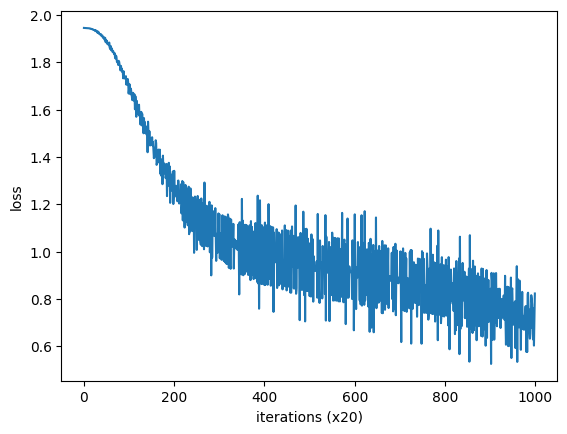

In [13]:
#CBOWモデルの学習
import sys
sys.path.append('..')  # 親ディレクトリのファイルをインポートするための設定
from common.trainer import Trainer #重みの重複を防ぐためのTrainerクラスのインポート
from common.optimizer import Adam
from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot


window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

学習を重ねるごとに損失が減少しているのが分かります。

In [14]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [-1.1282866  1.2089064 -1.1435604  1.13396    1.2402496]
say [ 1.2077012  -1.21684     1.2242444  -0.87535524 -1.2355232 ]
goodbye [-0.8134243   0.72410756 -0.7776973   0.8222961   0.6323273 ]
and [ 0.8330256  -0.87201333  0.72494376 -1.9347136  -0.8977146 ]
i [-0.79250336  0.6916333  -0.77600557  0.82899094  0.6247894 ]
hello [-1.1339666  1.2051038 -1.137324   1.1526849  1.2307045]
. [ 1.2757143 -1.2590611  1.3660262  1.0146358 -1.2304595]


学習の結果、上のような単語の分散表現が得られました。  
  
前章で扱ったカウントベースの手法よりも密なベクトルになっているのが分かります。

## skip-gramモデル

word2vecでは2つのモデルが提案されました。1つはCBOW、2つ目がskip-gramモデルです。  
  
skip-gramモデルが解く問題はCBOWで扱ったコンテキストとターゲットが逆転したものになります。

![alt text](../pictures/pict13.png)

![alt text](../pictures/pict14.png)

ではCBOWモデルとskip-gramモデルのどちらのほうが優れているでしょうか？  
  
最終的に得られる単語の分散表現だけ見るとskip-gramモデルの方が良い結果が得られると言えます。  
  
しかし、学習速度の点だけ見るとCBOWモデルのほうが速いです。  
  
今回は使いませんでしたがskip-gramモデルのコードも載せておきます。

In [15]:
#Skip-gramモデルの実装
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # レイヤの生成
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()

        # すべての重みと勾配をリストにまとめる
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:, 0])
        l2 = self.loss_layer2.forward(s, contexts[:, 1])
        loss = l1 + l2
        return loss

    def backward(self, dout=1):
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)

## カウントベース vs 推論ベース

この章のはじめに述べた通りカウントベースには問題点があり、推論ベース（特にword2vec）はそれを解決するために提案されました。  
  
改めて両者を様々な観点で比べてみましょう。  
  
1. 語彙を新たに追加する場合の分散表現の更新

カウントベースではゼロから計算を行う必要があり、微調整が苦手でした。  
  
一方、推論ベースはパラメータの再学習をすることができるため、そこまでの学習経験を損なわずに分散表現の更新ができます。  
  
この観点では推論ベースに軍配が上がります。  

2. 単語の分散表現の性質、精度  

カウントベースの方は単語の分散表現は単語同士の類似性がエンコードされています。  
  
一方推論ベース、特にskip-gramを用いたword2vecでは単語の類似性に加えて複雑な単語のパターンも捉えることができることがわかっています。  
  
例としては「king - man + woman = queen」のような推論問題も解くことができるのが有名です。  
  
ただ、これらはあくまでそれぞれの性質であり、精度は優劣がつけられないというのが現在の結論です。  
  
